## **Classez des images**

### partie 2/4 : modèle perso

<br>

> #### notebook de mise en oeuvre de création et d’entraînement du modèle personnel, des simulations des différentes valeurs des hyperparamètres et de data augmentation.. <br><br>

<br>


## 0 Imports


### 0.1 Librairies, réglages


In [2]:
# paths, folders/files
import os, sys, random, re
from os import listdir
from glob import glob
from zipfile import ZipFile
import time
import json

# math, dataframes
import numpy as np
import pandas as pd
from pandarallel import pandarallel
from collections import Counter

# Visualisation
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import plotly.express as px
# from wordcloud import WordCloud
# from PIL import Image
from optuna.visualization import plot_optimization_history

# Feature engineering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn import manifold, decomposition
from sklearn import cluster, metrics
from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import CountVectorizer

# NN
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC
from sklearn.metrics import f1_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import keras_tuner as kt
import optuna
%pip install optuna-integration
from optuna_integration import TFKerasPruningCallback
from functools import partial

# tracking
from mlflow import MlflowClient
import mlflow.keras

# ! REQUIRES CONSOLE COMMAND : mlflow ui
# depuis dossier notebooks
os.environ['MLFLOW_TRACKING_URI'] = './'
# Utilisable seulement en local ?
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

import pickle


print('\nPython version ' + sys.version)
print('Tensorflow version ' + tf.__version__)
print('Mlflow Autolog compatible with: 2.2.4 <= keras <= 2.6.0')
print('Keras version ' + tf.keras.__version__)
# no autolog... ?

# plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)


2024-04-02 22:33:32.388268: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Note: you may need to restart the kernel to use updated packages.

Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
Tensorflow version 2.12.0
Mlflow Autolog compatible with: 2.2.4 <= keras <= 2.6.0
Keras version 2.12.0

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 0.2 Variables globales


In [3]:
nb_classes = 4      # min 2, max 120 (theorique, en pratique les dataframes préparés sont : 3, 4, 5, 10)
                    # possible d'en creer + en utilisant le ntbk 1
norm = True

size_wh = 128
target_size=(size_wh, size_wh)  # pour grille 5x5, stride (2,2) ?

test_size = 0.15    # same for validation

alea = 42   # pour fixer les ttsplits et tjs travailler sur les mm datasets
# En revanche l'initialisation des poids des modèles restera aléatoire,
# pour pouvoir comparer les resultats sur +ieurs runs.

nb_runs = 1     # 2-3 le matin, 50 le soir
                # avec keras-tuner / optuna, plus besoin de runs multiples..
                # à la place on a des trials multiples !

n_trials = 1    # 10

for i in [3, 4, 5, 10]:
    try:
        pickle_path_model = f'./pickle/best_{i}/ze_model.pkl'
        pickle_path_accuracy = f'./pickle/best_{i}/best_accuracy_val.pkl'
        pickle_path_params = f'./pickle/best_{i}/best_params.pkl'

        best_acc = pickle.load(open(pickle_path_accuracy, 'rb'))
        best_parameters = pickle.load(open(pickle_path_params, 'rb'))
        # Parse the JSON string into a dictionary
        # best_parameters = json.loads(best_parameters_string)
    except:
        best_acc = 1 / nb_classes   # proba prediction random, baseline
        best_parameters = {}

    print('\n', f'Best accuracy val on {i} classes :')
    print(best_acc, '\n')
    print('Best_parameters :', '\n')
    pprint(best_parameters)

print('\n', f'Nb de classes prises en compte ds ce ntbk : {nb_classes}')
print(f'Normalization : {norm}')


pickle_path_model = f'./pickle/best_{nb_classes}/ze_model.pkl'
pickle_path_accuracy = f'./pickle/best_{nb_classes}/best_accuracy_val.pkl'
pickle_path_params = f'./pickle/best_{nb_classes}/best_params.pkl'

try:
    best_acc = pickle.load(open(pickle_path_accuracy, 'rb'))
    best_parameters = pickle.load(open(pickle_path_params, 'rb'))
    epochs = best_parameters['nb epochs']
    if 'no_norm' in best_parameters['preprocessing']:
        norm = False

except:
    best_acc = 1 / nb_classes   # proba prediction random, baseline
    best_parameters = {}
    epochs = 15


val_acc_ref = 0

features_to_test = ['resized', 'expo', 'contraste', 'denoised_g', 'denoised_bi', 'denoised_nl',
                    'preprocess_complet']

all_features_to_test = ['photo_path'] + features_to_test

try:
    feature = best_parameters['feature']
    if feature == 'originale, photo_path':
        feature = 'photo_path'
except:
    feature = 'photo_path'



 Best accuracy val on 3 classes :
0.7692307829856873 

Best_parameters : 

{'activation': 'tanh',
 'conv_1_units': 12,
 'conv_2_units': 20,
 'dense_units': 192,
 'dim images': '128 x 128 x 3',
 'feature': 'originale, photo_path',
 'model': 'V3',
 'nb epochs': 15,
 'preprocessing': 'norm',
 'size val test sets': 0.15,
 'target': '3_classes',
 'tuner/bracket': 1,
 'tuner/epochs': 15,
 'tuner/initial_epoch': 5,
 'tuner/round': 1,
 'tuner/trial_id': '0019'}

 Best accuracy val on 4 classes :
0.6235294342041016 

Best_parameters : 

{'dim images': '128 x 128 x 3',
 'feature': 'expo',
 'model': 'V1',
 'nb epochs': 15,
 'preprocessing': 'no_norm',
 'size val test sets': 0.15,
 'target': '4_classes'}

 Best accuracy val on 5 classes :
0.6666666865348816 

Best_parameters : 

{'activation': 'tanh',
 'conv_1_units': 16,
 'conv_2_units': 8,
 'dense_units': 224,
 'dim images': '128 x 128 x 3',
 'feature': 'originale, photo_path',
 'model': 'V3',
 'nb epochs': 15,
 'preprocessing': 'no_norm',
 'si

### 0.3 Fonctions


In [4]:
# tracking manuel

model_results = []

def affichage_results(multiple=True, best_acc=best_acc):
    """Tracking manuel de nos modèles (data, params, tps, scores) pour comparaison."""

    print(f'{nb_classes} classes prédites')
    print(f'dim images : {size_wh} x {size_wh} x 3')
    print(f'size validation & testing sets : {test_size}')
    print(f'nb epochs : {epochs}', '\n')
    print(f'current best accuracy (validation set) : {best_acc}')

    if multiple:
        print(f'nb runs: {nb_runs}', '\n')

    # Create a DataFrame from the list of model results
    model_comparison_df = pd.concat([pd.DataFrame(model_results)], ignore_index=True)

    # Sort the DataFrame by precision in descending order (higher is better)
    model_comparison_df.sort_values(by='accuracy_val_moy', ascending=False, inplace=True)

    # Display the sorted DataFrame
    display(model_comparison_df)


# tracking mlflow

def create_mlflow_experiment(
    experiment_name: str, artifact_location: str, tags: dict[str, str]
) -> str:
    """
    Create a new mlflow experiment with the given name and artifact location.

    Parameters:
    ----------
    experiment_name: str
        The name of the experiment to create.
    artifact_location: str
        The artifact location of the experiment to create.
    tags: dict[str,Any]
        The tags of the experiment to create.

    Returns:
    -------
    experiment_id: str
        The id of the created experiment.
    """
    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name, artifact_location=artifact_location, tags=tags
        )
    except:
        print(f"Experiment {experiment_name} already exists.")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

    mlflow.set_experiment(experiment_name=experiment_name)

    return experiment_id


def get_mlflow_experiment(
    experiment_id: str = None, experiment_name: str = None
) -> mlflow.entities.Experiment:
    """
    Retrieve the mlflow experiment with the given id or name.

    Parameters:
    ----------
    experiment_id: str
        The id of the experiment to retrieve.
    experiment_name: str
        The name of the experiment to retrieve.

    Returns:
    -------
    experiment: mlflow.entities.Experiment
        The mlflow experiment with the given id or name.
    """
    if experiment_id is not None:
        experiment = mlflow.get_experiment(experiment_id)
    elif experiment_name is not None:
        experiment = mlflow.get_experiment_by_name(experiment_name)
    else:
        raise ValueError("Either experiment_id or experiment_name must be provided.")

    return experiment


In [5]:
def save_model_if_better_than_the_best(model, acc, best_params):

    global best_acc

    if acc > best_acc:
        print(f'Improving! Accuracy up to {acc}')
        best_acc = acc
        # erreur logging, saving instead
        # using mlflow
        # mlflow.keras.save_model(model, "./best_model") # works only once
        # using pickle
        with open(pickle_path_model, 'wb') as f:
            pickle.dump(model, f)
        # also save best accuracy
        with open(pickle_path_accuracy, 'wb') as f:
            pickle.dump(best_acc, f)
        # and corresponding best params
        with open(pickle_path_params, 'wb') as f:
            pickle.dump(best_params, f)

data= pd.DataFrame()

def feature_to_array(feature="photo_path", norm=False, shape_result=False, expand=False, predict=False):
    X_feature = []

    for image_file in data[feature] :
        image = load_img(image_file, target_size=target_size)
        image = img_to_array(image)
        if norm:
            image = image / 255
        if expand:
            image = np.expand_dims(image, axis=0)
        if predict:
            X_feature.append(best_model_block_1.predict(image, verbose=0)[0])
        else:
            X_feature.append(image)

    X_feature = np.asarray(X_feature)

    if shape_result:
        pprint(X_feature[:1])
        print('\n', "Shape of X_train:", X_feature.shape)
        # ok

    return X_feature


### 0.4 Metriques


In [6]:
# J'utiliserai tjs les noms anglais des métriques ici,
# pour éviter la confusion précision (fr) != precision (en),
# et pour simplement garder les noms des fonctions importées depuis tf.keras.metrics

# Nous sommes dans un cas de classification "classique", 1 classe prédite.
# Une première métrique simple et intuitive est donc l'accuracy :
# nb de prédictions correctes / nb total de prédictions.
# Cette métrique nous suffit déjà pour comparer et optimiser nos modèles.

# Si l'on souhaite étudier + en détail les prédictions des modèles, on utilisera
# la precison et le recall

# Precison (TP / (TP + FP)) :
# Une précision élevée signifie que si une classe est prédite par le modèle,
# alors il y a une forte probabilité (égale à la precision)
# que le chien appartienne en effet à cette classe.

# Recall (TP / (TP + FN)) :
# pour évaluer la capacité des modèles à identifier toutes les instances positives.
# Exemple : Si notre precision est égale à 1, c'est parfais, cela signifie que
# pour une une classe au moins, toutes les valeurs prédites par le modèle sont correctes.
# Cependant, il est possible que cela ne concerne que très peu de cas (mettons, 1 ou 2 prédictions)
# et qu'à côté de cela le modèle a pu faire des milliers de prédictions incorrectes,
# la precision seule ne nous le dit pas.

# Comme l'amélioration de la precision se fait svt au détriment du recall, en pratique
# on combine souvent les 2 avec le f1score (= moyenne harmonique)
# (2 x precision x recall) / (precision + recall)
# qui nous donne directement une idée du compromis precision / recall

# petit souci : le f1score et keras, c'est tout une histoire...
# Dans les versions récentes (depuis la 2.15.0 il me semble), le f1score est supprimé
# du module metrics, tt comme precision() et recall().
# Contrairement à l'accuracy, qui est calculée par époque lors du fit,
# le f1score (&precision, recall) étaient calculés par batch par défaut,
# nécessitant la mise en place d'une fonction de callback pour avoir des métriques
# cohérentes avec l'accuracy, et interprétables.

# En +, conda a bcp de mal à résoudre un env avec ces versions,
# incompatibles avec les requirements d'autres packages dans l'env.

# Dans les versions + anciennes de keras, le f1score était dans un autre module, "addons",
# mais ce moule est désormais déprécié.

# Solutions :

# - On pourrait utiliser addons qd mm, mais pas pour longtemps.
# - définir un f1score custom
# Pas évident car tensorflow est très pointilleux sur les types d'objets qu'il accepte.
# Exemple : cette fonction est construite en utilisant 2 fonctions tf.keras,
# pourtant elle renvoit une erreur si on tente de l'utiliser parce que le type retourné est
# un float.

def custom_f1score(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    f1 = (2*precision*recall) / (precision + recall)

    return f1

# Autre solution possible, utiliser le f1score de sk-learn. Là encore cela demande des ajustements.

# -> Utilisons simplement l'accuracy pour entrainer les modeles,
# nous reviendrons aux métriques + fines pour l'analyse des prédictions
# (tables de confusion, etc...)

metrics=[
    'Accuracy',
]


### 0.4 Data


In [7]:
data = pd.read_csv(f'./data/data_{nb_classes}_classes.csv', sep=',')

print(data.shape)
data.head()


(942, 11)


,photo_path,breed,width,height,resized,expo,contraste,denoised_g,denoised_bi,denoised_nl,preprocess_complet
0,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
1,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,375,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
2,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,400,500,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
3,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...
4,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,375,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...


### 0.5 Etude de faisabilité (sort of)


In [8]:
# recuperation du meilleur modele

best_model = pickle.load(open(pickle_path_model, 'rb'))

print(best_model.summary())


2024-04-02 22:33:36.201017: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68 (Conv2D)          (None, 124, 124, 6)       456       
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 62, 62, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 29, 29, 16)       0         
 g2D)                                                            
                                                                 
 flatten_34 (Flatten)        (None, 13456)             0         
                                                                 
 dense_68 (Dense)            (None, 60)              

In [9]:
best_model_block_1 = Model(inputs=best_model.inputs, outputs=best_model.layers[-2].output)

print(best_model_block_1.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_68_input (InputLayer  [(None, 128, 128, 3)]    0         
 )                                                               
                                                                 
 conv2d_68 (Conv2D)          (None, 124, 124, 6)       456       
                                                                 
 max_pooling2d_68 (MaxPoolin  (None, 62, 62, 6)        0         
 g2D)                                                            
                                                                 
 conv2d_69 (Conv2D)          (None, 58, 58, 16)        2416      
                                                                 
 max_pooling2d_69 (MaxPoolin  (None, 29, 29, 16)       0         
 g2D)                                                            
                                                             

In [10]:
# Ici l'étude de faisabilité préconisée par la méthode Agile n'est pas vraiment utile en tant que telle
# (On sait que le projet est faisable). Il s'agit plutôt de pouvoir observer le travail effectué par le
# modèle

images_features = []


for image_file in data[feature]: # try shuffle ?
    image = load_img(image_file, target_size=(size_wh, size_wh))
    image = img_to_array(image)
    if norm:
        image = image / 255
    image = np.expand_dims(image, axis=0)
    images_features.append(best_model_block_1.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape


(942, 60)

In [11]:
# Reshape images to flatten them into vectors
flattened_images = images_features.reshape(images_features.shape[0], -1)
print(flattened_images.shape)

# Normalize the data
scaler = StandardScaler()
normalized_images = scaler.fit_transform(flattened_images)


(942, 60)


### 0.6 Réduction dim


In [12]:
# PCA

print(normalized_images.shape) # same as flattened_images

pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(normalized_images)

print(feat_pca.shape)

# dimention divisée par 200 (presque), en conservant 99% de la variance !


(942, 60)
(942, 54)


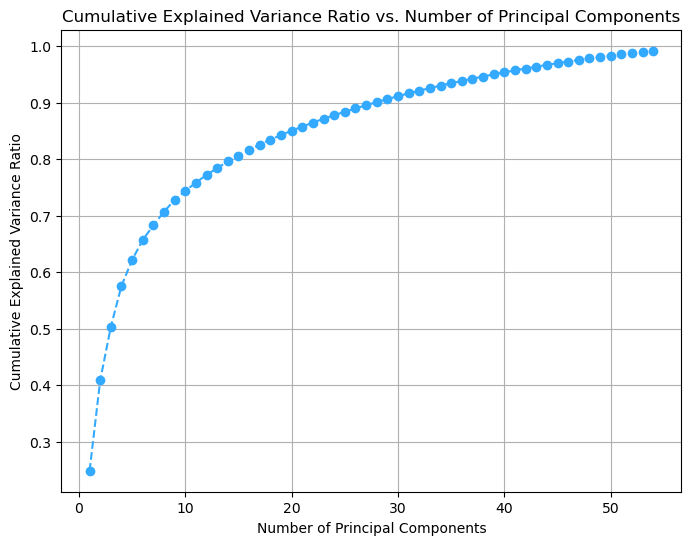

In [13]:
# Plot explained variance ratio
plt.figure(figsize=(8, 6))
plt.plot(range(1, pca.n_components_ + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--', color='#3af')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs. Number of Principal Components')
plt.grid(True)
plt.show()

# Pourquoi on a besoin du tsne pour la visu : en 2D ou même en 3D, les 3 premiers vecteurs propres
# # fournis par la PCA ne captent "que" (environ) un tiers de l'information.
# Ce qu'on verrait serait très déformé par les projections successives de la PCA.
# tester ?


### 0.7 tsne


In [14]:
# t-sne

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)


In [15]:
# encodage target

label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(data["breed"])

data["target"] = label_encoder.transform(data["breed"])

display(data.head(1))
data.tail(1)


,photo_path,breed,width,height,resized,expo,contraste,denoised_g,denoised_bi,denoised_nl,preprocess_complet,target
0,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...,1


,photo_path,breed,width,height,resized,expo,contraste,denoised_g,denoised_bi,denoised_nl,preprocess_complet,target
941,./data/cleaned_data/0_format/-pomeranian/n0211...,pomeranian,500,376,./data/cleaned_data/1_resized_128/-pomeranian/...,./data/cleaned_data/2_expo_128/-pomeranian/n02...,./data/cleaned_data/3_contraste_128/-pomerania...,./data/cleaned_data/4_gauss_denoised_128/-pome...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-p...,./data/cleaned_data/7_preprocess_complet_128/-...,2


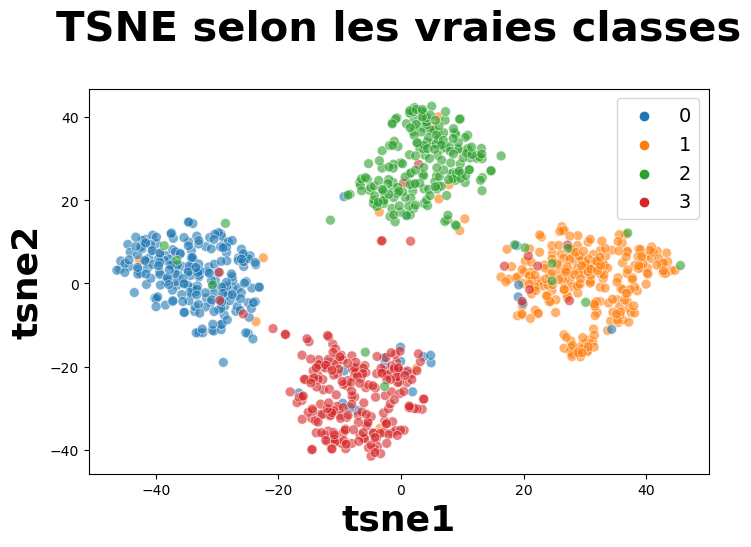

In [16]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["target"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=nb_classes), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

# Ca marche mieux !
# (sinon verifier variable globale norm, depend des modeles)
# verifier + tard uniquement sur jeu test


## images mal classées


In [17]:
# mat conf direct ?
# ou on essaie d'abord de reentrainer sur train_val ?
# avec early stop ?

for layer in best_model.layers:
        layer.trainable = False


In [19]:
# tsne sur les vrai classes, training + val set uniquement

X_feature = feature_to_array(feature=feature, norm=norm, expand=False, predict=False) # model
# X_feature = feature_to_array(feature=feature, norm=norm, expand=True, predict=True) # -> pca tsne
y_target = np.asarray(data["target"])

X_train, X_test, y_train, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_target)

y_train_ohe = tf.keras.utils.to_categorical(y_train)
y_test_ohe = tf.keras.utils.to_categorical(y_test)


# Fit model again ?
# best_model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32, verbose=0)


In [25]:
# predict

# predicted_classes = model.predict_classes(X_test) # deprecated

predictions_all = best_model.predict(X_feature)
predicted_classes_all = np.argmax(predictions_all, axis=1)

predictions_test = best_model.predict(X_test)
predicted_classes_test = np.argmax(predictions, axis=1)


3/3 [==============================] - 0s 28ms/step


In [27]:
data['predictions'] = predicted_classes_all
data.head()


,photo_path,breed,width,height,resized,expo,contraste,denoised_g,denoised_bi,denoised_nl,preprocess_complet,target,predictions
0,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...,1,1
1,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,375,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...,1,1
2,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,400,500,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...,1,1
3,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,333,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...,1,1
4,./data/cleaned_data/0_format/-maltese_dog/n020...,maltese_dog,500,375,./data/cleaned_data/1_resized_128/-maltese_dog...,./data/cleaned_data/2_expo_128/-maltese_dog/n0...,./data/cleaned_data/3_contraste_128/-maltese_d...,./data/cleaned_data/4_gauss_denoised_128/-malt...,./data/cleaned_data/5_bilateral_denoised_128/-...,./data/cleaned_data/6_nonlocal_denoised_128/-m...,./data/cleaned_data/7_preprocess_complet_128/-...,1,1


In [28]:
print(data.loc[~(data['predictions'] == data['target'])].shape)


(65, 13)


In [29]:
misclassified_in_test = 0
print(len(y_test))

for i in range(len(y_test)):
    if y_test[i] != predicted_classes_test[i]:
        misclassified_in_test += 1

print(misclassified_in_test)

# la moitié des erreurs st ds le jeu de test
# l'autre moitié, on parie c ds le jeu de val ?


95
32


In [ ]:
# mat conf


In [24]:
pprint(predicted_classes[:3])


array([2, 1, 2])


In [ ]:
# compare


In [17]:
# Reshape images to flatten them into vectors
flattened_images = X_train.reshape(X_train.shape[0], -1)
print(flattened_images.shape)

# Normalize the data
scaler = StandardScaler()
normalized_images = scaler.fit_transform(flattened_images)

pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(normalized_images)

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)


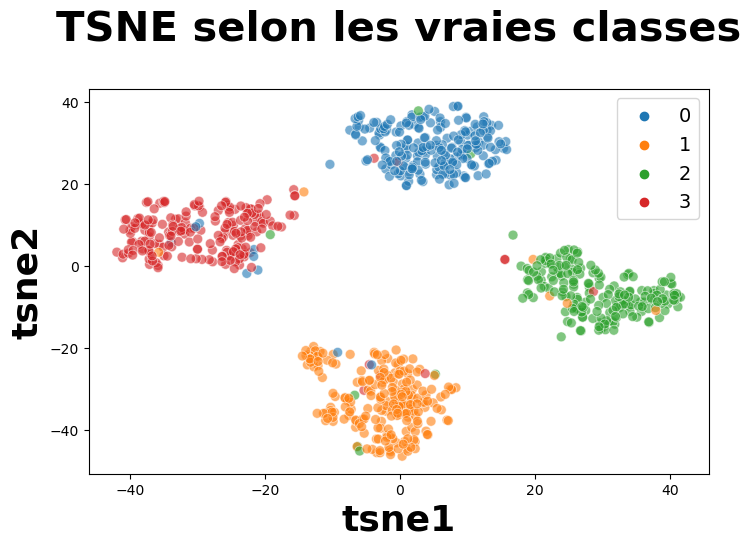

In [18]:
# factoriser !

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = y_train

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=nb_classes), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()


### testing set


In [19]:
# Reshape images to flatten them into vectors
flattened_images_test = X_test.reshape(X_test.shape[0], -1)
print(flattened_images_test.shape)

# Normalize the data
scaler = StandardScaler()
normalized_images_test = scaler.fit_transform(flattened_images_test)


(95, 60)


In [20]:
pca = decomposition.PCA(n_components=0.99)
feat_pca_test = pca.fit_transform(normalized_images_test)

tsne_test = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne_test = tsne_test.fit_transform(feat_pca_test)


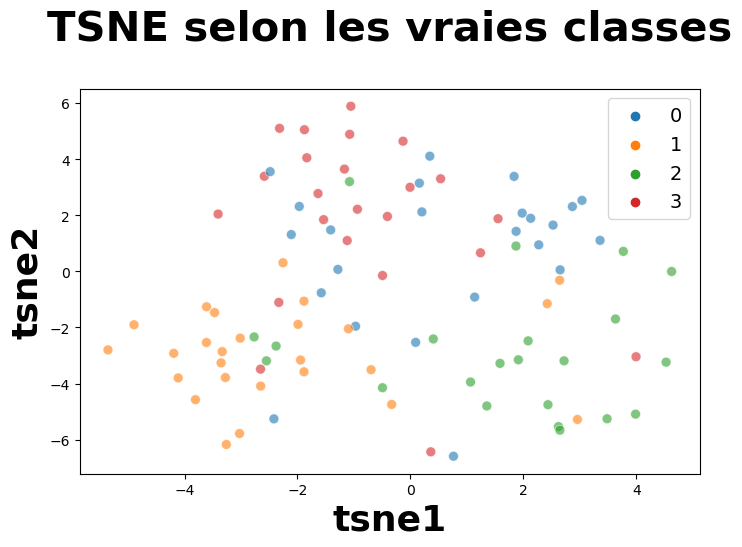

In [21]:
# factoriser !

df_tsne_test = pd.DataFrame(X_tsne_test, columns=['tsne1', 'tsne2'])
df_tsne_test["class"] = y_test

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=nb_classes), s=50, alpha=0.6,
    data=df_tsne_test,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()


### clusters


In [23]:
# retour au set complet
# factoriser !!!

flattened_images = X_feature.reshape(X_feature.shape[0], -1) # set complet
print(flattened_images.shape)

scaler = StandardScaler()
normalized_images = scaler.fit_transform(flattened_images)

pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(normalized_images)

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = y_target


(942, 60)


In [24]:
cls = cluster.KMeans(n_clusters=nb_classes, n_init=100)
cls.fit(X_tsne)


KMeans(n_clusters=4, n_init=100)

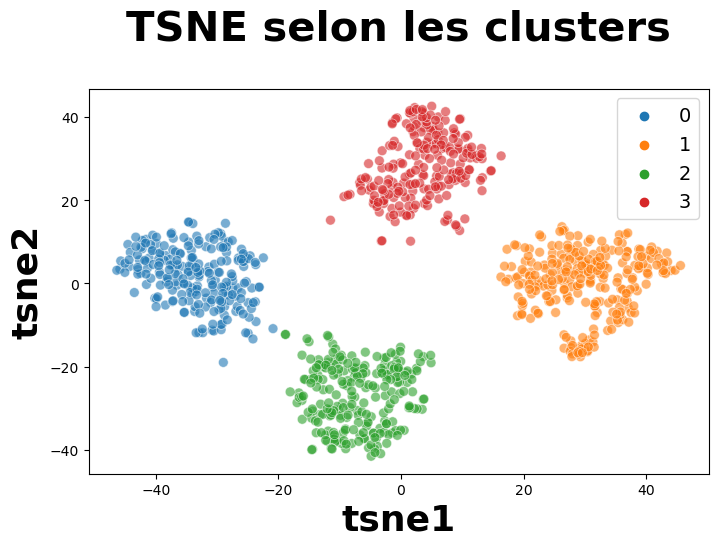

AttributeError: 'list' object has no attribute 'adjusted_rand_score'

In [27]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=4), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = data["target"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))


### data augmentation


In [16]:
# Pour mélanger les images, classées initalement par classe
# data = data.sample(frac=1, random_state=42).reset_index(drop=True) # ?


In [17]:
# Deprecated :

datagen = ImageDataGenerator(
    rotation_range=20,      # Rotate the image by random degrees in the range [-20, 20]
    width_shift_range=0.1,  # Shift the image horizontally by a fraction of total width
    height_shift_range=0.1, # Shift the image vertically by a fraction of total height
    shear_range=0.2,        # Shear intensity (angle in radians)
    zoom_range=0.2,         # Zoom the image by a random factor in the range [0.8, 1.2]
    horizontal_flip=True,  # Flip the image horizontally
    fill_mode='nearest'    # Strategy used for filling in newly created pixels
)


tf.keras.preprocessing.image_dataset_from_directory(
directory,
labels='inferred',
label_mode='int',
class_names=None,
color_mode='rgb',
batch_size=32,
image_size=(256, 256),
shuffle=True,
seed=None,
validation_split=None,
subset=None,
interpolation='bilinear',
follow_links=False,
crop_to_aspect_ratio=False,
pad_to_aspect_ratio=False,
data_format=None,
verbose=True
)


In [18]:
# + couches (telles que tf.keras.layers.Rescaling )


## 1 Création d'un nouveau modèle


### 1.1 LeNet inspired architecture


In [19]:
# on va garder la dim cette fois-ci

feature = 'photo_path' # preprocessing intégré
norm = False # Sécurité (+ param optuna_n_times())

def improved_model():
    model = Sequential()
    model.add(Conv2D(12, kernel_size=(5, 5), activation='tanh', input_shape=(size_wh, size_wh, 3),
                     padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(20, kernel_size=(5, 5), activation='tanh', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    # model.add(Dense(120, activation='tanh'))
    model.add(Dense(192, activation='tanh')) # *
    model.add(Dense(nb_classes, activation='softmax'))

    return model


model = improved_model()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

model.summary()

# * ?? 192 revient +ieurs fois, mais de bonnes performances semblent possibles
# avec un nb de neurones bcp - important (10, 20 ??)
# à vérifier sur + de classes


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 12)      912       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 12)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 20)        6020      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 20)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 192)               3

In [20]:
# option 1 : couches + epaisses

experiment_id = create_mlflow_experiment(
    experiment_name='optuna_aug',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V?", "preprocessing": 'no_norm', "feature": "photo_path", 'target': f'{nb_classes} classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment optuna_aug already exists.
Name: optuna_aug


In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(size_wh, size_wh),
  layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])


In [22]:
# Contrairement à keras tuner, qui sauvegarde par défaut le résultat obtenu sur le disque,
# optuna refait les tests à chaque run


def build_model_1(conv_1_units, filter1, conv_2_units, filter2, fc_1_units, metrics=metrics):
    model = Sequential()
    # preprocessing
    model.add(resize_and_rescale)
    # data_augmentation
    model.add(data_augmentation)

    model.add(Conv2D(conv_1_units, kernel_size=(filter1, filter1),
                     activation="tanh", padding='same'))
    model.add(Conv2D(conv_1_units, kernel_size=(filter1, filter1),
                     activation="tanh", padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(conv_2_units, kernel_size=(filter2, filter2),
                     activation="tanh", padding='same'))
    model.add(Conv2D(conv_2_units, kernel_size=(filter2, filter2),
                     activation="tanh", padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(fc_1_units*3, activation='tanh'))
    model.add(Dense(fc_1_units, activation='tanh'))
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

    return model


def objective_1(trial, X_train, y_train_ohe, X_val, y_val_ohe):
    # Define a pruning callback
    pruning_callback = TFKerasPruningCallback(trial, "val_Accuracy")

    # Parameters to optimize
    conv_1_units = trial.suggest_int('conv_1_units', 10, 50, step=10)
    filter1 = trial.suggest_int('filter1', 3, 5, step=2)
    conv_2_units = trial.suggest_int('conv_2_units', 10, 50, step=10)
    filter2 = trial.suggest_int('filter2', 3, 5, step=2)
    fc_1_units = trial.suggest_int('fc_1_units', 10, 250, step=30)

    # Build and compile the model with the suggested parameters
    model = build_model_1(conv_1_units, filter1, conv_2_units, filter2, fc_1_units)

    # Train the model
    history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                        validation_data=(X_val, y_val_ohe),
                        callbacks=[pruning_callback], verbose=0)

    # Print history for debugging
    # pprint(history.history)

    # Evaluate the model on the validation set
    val_acc = history.history['val_Accuracy'][-1]

    return val_acc


def test_optuna_n_times_1(feature=feature, epochs=epochs, n=nb_runs, norm=False, model_name='V?',
                        n_trials=n_trials):
    parameters = {
        "model": "V?",
        "preprocessing": 'no_norm, layer',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    results_val_acc, results_time_fit,  results_time_predict = [], [], []

    # feature, target
    # gain de tps hors de la boucle,
    # ! seulement si random_state=alea

    X_feature = feature_to_array(feature, norm=norm)
    y_target = np.asarray(data["target"])

    X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_target)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_train_val)

    y_train_ohe = tf.keras.utils.to_categorical(y_train)
    y_val_ohe = tf.keras.utils.to_categorical(y_val)
    y_test_ohe = tf.keras.utils.to_categorical(y_test)

    # Create a partially applied objective function with fixed arguments
    partial_objective = partial(objective_1, X_train=X_train, y_train_ohe=y_train_ohe, X_val=X_val, y_val_ohe=y_val_ohe)

    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    study.optimize(partial_objective, n_trials=n_trials)

    for i in range(n):
        with mlflow.start_run(run_name=f'run_{i}', nested=True) as kid:
            print(f'\nRun {i}\n')
            print("RUN ID ", kid.info.run_id)

            # plot_optimization_history(study)

            # Fetch the best parameters
            best_trial = study.best_trial
            best_params = best_trial.params

            # Build the model with the best parameters
            model = build_model_1(**best_params) # archi opti but untrained

            # Fit model and time it
            time_fit_start = time.time()
            model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                    validation_data=(X_val, y_val_ohe), verbose=0)
            time_fit_end = time.time()
            time_fit = time_fit_end - time_fit_start
            # time_fit = 0 # en attendant
            model.summary()

            # Time predictions
            time_predict_start = time.time()
            _, val_acc = model.evaluate(X_val, y_val_ohe)
            time_predict_end = time.time()
            time_predict = time_predict_end - time_predict_start

            # print(f'Val accuracy (feature={feature}): {val_acc}')

            parameters.update(best_params)
            mlflow.log_params(parameters)

            save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

            metriq = {
                "accuracy_val": val_acc,
                "time_fit": time_fit,
                "time_predict": time_predict
            }
            mlflow.log_metrics(metriq)

            results_val_acc.append(val_acc)
            results_time_fit.append(time_fit)
            results_time_predict.append(time_predict)

    # Calculate averages
    mean_val_acc = np.mean(results_val_acc)
    mean_time_fit = np.mean(results_time_fit)
    mean_time_predict = np.mean(results_time_predict)

    # Calculate standard deviations
    std_val_acc = np.std(results_val_acc)

    metrix = {
        "accuracy_val_moy": mean_val_acc,
        "accuracy_val_std": std_val_acc,
        "time_fit_moy": mean_time_fit,
        "time_predict_moy": mean_time_predict
    }
    for run in range(nb_runs):
        metrix[f'accuracy_val_run_{run}'] = results_val_acc[run]

    # multiple metrics
    mlflow.log_metrics(metrix)

    results = {'model': model_name,
               'df': 'data_3_classes',
               'feature': feature,
               'accuracy_val_moy': mean_val_acc,
               'accuracy_val_std': std_val_acc,
               'time_fit_moy (s)': mean_time_fit,
               'time_predict_moy (s)': mean_time_predict,
              }

    # Append a new row for this model
    model_results.append(results)

    print('\n', f'Accuracy val {feature}, moyenne : {mean_val_acc}')
    print(f'Accuracy val {feature}, écart-type : {std_val_acc}')

    return metrix


# _ = test_optuna_n_times_1()


In [23]:
with mlflow.start_run(run_name="optuna_+", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V?",
        "preprocessing": 'no_norm, layer',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_optuna_n_times_1()

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)


# interessant

# 'fc_1_units': 10
# prendre 2-3x le nb de classes ?
# Trial 3 finished with value: 0.5764706134796143 and parameters: {'conv_1_units': 24, 'filter1': 3, 'conv_2_units': 8, 'filter2': 5, 'fc_1_units': 10}. Best is trial 3


[I 2024-04-02 21:11:15,983] A new study created in memory with name: no-name-43a0adca-b313-4ab9-84b5-937e5ea4cd59
[I 2024-04-02 21:15:58,757] Trial 0 finished with value: 0.35384616255760193 and parameters: {'conv_1_units': 30, 'filter1': 5, 'conv_2_units': 40, 'filter2': 3, 'fc_1_units': 70}. Best is trial 0 with value: 0.35384616255760193.



Run 0

RUN ID  d6e64e0f3d804cd88ec434581e88524f
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 sequential_2 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 30)      2280      
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 30)      22530     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 30)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 40)        10840     
     

In [24]:
affichage_results(best_acc=best_acc)


3 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.7692307829856873
nb runs: 1 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
0,V?,data_3_classes,photo_path,0.353846,0.0,308.438268,0.757559


Chat gpt : (can you give me a general chronological timeline of the most imporant cnn models ? for each one, describe general architecture and innovation(s))

Certainly! Here's a chronological timeline of some of the most important CNN (Convolutional Neural Network) models along with their general architectures and key innovations:

1. **LeNet-5 (1998)**:

   - **Architecture**: LeNet-5 was one of the earliest CNN architectures proposed by Yann LeCun et al. for handwritten digit recognition. It consists of seven layers: two convolutional layers, two pooling layers, and three fully connected layers.
   - **Innovations**: LeNet-5 introduced the concept of convolutional layers, pooling layers, and the use of the backpropagation algorithm for training convolutional neural networks. It also demonstrated the effectiveness of CNNs for handwritten digit recognition tasks.

2. **AlexNet (2012)**:

   - **Architecture**: AlexNet, proposed by Alex Krizhevsky et al., was the winner of the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) in 2012. It consists of eight layers, including five convolutional layers followed by max-pooling layers, and three fully connected layers.
   - **Innovations**: AlexNet significantly advanced the field of computer vision by demonstrating the effectiveness of deep CNNs for large-scale image classification tasks. It introduced concepts such as rectified linear activation units (ReLU), dropout regularization, and data augmentation.

3. **VGGNet (2014)**:

   - **Architecture**: VGGNet, proposed by Karen Simonyan and Andrew Zisserman, is characterized by its simplicity and uniform architecture. It consists of 16 convolutional layers with 3x3 filters, followed by max-pooling layers, and three fully connected layers.
   - **Innovations**: VGGNet demonstrated that increasing network depth (number of layers) leads to improved performance on image recognition tasks. Its uniform architecture made it easy to understand and replicate, paving the way for deeper CNN architectures.

4. **GoogLeNet (Inception v1) (2014)**:

   - **Architecture**: GoogLeNet, proposed by Szegedy et al. from Google Research, introduced the concept of inception modules, which consist of multiple parallel convolutional layers with different filter sizes and pooling operations. It contains 22 layers in total.
   - **Innovations**: The inception module reduces computational complexity while increasing the representational power of the network. GoogLeNet demonstrated that CNNs with more diverse architectures can achieve high accuracy while being computationally efficient.

5. **ResNet (2015)**:

   - **Architecture**: ResNet, proposed by Kaiming He et al., introduced the concept of residual connections, which bypass the convolutional layers and directly feed the input to the output. It consists of deep residual blocks with skip connections.
   - **Innovations**: ResNet addressed the problem of vanishing gradients in very deep networks by allowing the network to learn residual functions. This enabled training of extremely deep neural networks with hundreds or even thousands of layers.

6. **Inception v3 (2015)**:

   - **Architecture**: Inception v3, an extension of GoogLeNet, further refined the inception module and introduced additional optimizations such as factorized convolutions and batch normalization. It contains 48 layers.
   - **Innovations**: Inception v3 improved the efficiency and accuracy of the inception module by reducing the number of parameters and computational cost. It achieved state-of-the-art performance on image classification and object detection tasks.

7. **MobileNet (2017)**:

   - **Architecture**: MobileNet, proposed by Howard et al., is designed for mobile and embedded vision applications with limited computational resources. It utilizes depthwise separable convolutions to reduce the number of parameters and computation.
   - **Innovations**: MobileNet demonstrated the feasibility of deploying lightweight CNN architectures on resource-constrained devices without sacrificing performance. It paved the way for applications such as real-time object detection and image classification on mobile devices.

8. **EfficientNet (2019)**:
   - **Architecture**: EfficientNet, proposed by Tan and Le, introduces a compound scaling method to balance network depth, width, and resolution for better efficiency and accuracy. It consists of multiple scaling stages with progressively larger network architectures.
   - **Innovations**: EfficientNet achieves state-of-the-art performance by efficiently scaling up the network size in a principled manner. It demonstrated that better performance can be achieved by balancing model size and computational cost.

These are just a few notable CNN architectures, and there are many more models and variations developed over the years. Each of these models has contributed to advancing the field of computer vision and has inspired further research and innovation in deep learning.


In [25]:
# Pour l'instant notre modele est tjs tres proche d'un LeNet-5 de 1998,
# les seules différences sont l'ajout de couches de convolution supplementaires,
# et une couche fully-connected remplacée par une flattening layer.
# On est encore au XXeme siècle !!

# AlexNet (2012) : tester dropout regularization et data augmentation
# VGGNet : de combien peut-on augmenter le nombre de couches de notre modèle perso ?
# (fin opti ici)

# A partir de VGG et pour les modèles suivant, voir partie 3, transfer learning (prochain ntbk) :

# Le module Inception de GoogLeNet integre directement des elements de data augmentation dans les
# premieres couches du reseau neuronal (en particulier pour les zooms), en plus de
# l'extraction de feature propre aux CNNs.

# ResNet, dont l'archi permet de construire des reseaux (beaucoup) + profonds
# Inception v3 (2015): factorized convolutions and batch normalization ?
# MobileNet, how much lighter and how ? "depthwise separable convolutions" ?
# EfficientNet: compound scaling method ?


### dropout


In [26]:
experiment_id = create_mlflow_experiment(
    experiment_name='dropouts',
    artifact_location="./mlruns/artifacts",
    tags={"model": "V?", "preprocessing": 'no_norm', "feature": "photo_path", 'target': f'{nb_classes} classes'},
)

experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


Experiment dropouts already exists.
Name: dropouts


In [27]:
# option 2, + de couches

# dropout
# + batch size

def build_model_2(conv_1_units, conv_filter, conv_2_units, conv_3_units, fc_1_units, drop1, drop2):
    model = Sequential()
    # preprocessing
    model.add(resize_and_rescale)
    # data_augmentation
    model.add(data_augmentation)

    model.add(Conv2D(conv_1_units, kernel_size=(conv_filter, conv_filter),
                     activation="tanh", padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop1))
    model.add(Conv2D(conv_2_units, kernel_size=(conv_filter, conv_filter),
                     activation="tanh", padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop1))
    model.add(Conv2D(conv_3_units, kernel_size=(conv_filter, conv_filter),
                     activation="tanh", padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(drop1))
    model.add(Flatten())
    model.add(Dense(fc_1_units*2, activation='tanh'))
    model.add(Dense(fc_1_units, activation='tanh'))
    model.add(Dropout(drop2))  # Add dropout after the fully connected layer with a dropout rate of 0.5
    model.add(Dense(nb_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

    return model


def objective_2(trial, X_train, y_train_ohe, X_val, y_val_ohe):
    # Define a pruning callback
    pruning_callback = TFKerasPruningCallback(trial, "val_Accuracy")

    # Parameters to optimize
    conv_1_units = trial.suggest_int('conv_1_units', 4, 32, step=4)
    conv_filter = trial.suggest_int('conv_filter', 3, 5, step=2)
    conv_2_units = trial.suggest_int('conv_2_units', 4, 32, step=4)
    conv_3_units = trial.suggest_int('conv_3_units', 4, 32, step=4)
    fc_1_units = trial.suggest_int('fc_1_units', 10, 250, step=30)
    drop1 = trial.suggest_float('drop1', 0, 0.5)
    drop2 = trial.suggest_float('drop2', 0, 0.5)
    # batch = trial.suggest_int('batch', 32, 96, step=32)
    batch = 32

    # Build and compile the model with the suggested parameters
    model = build_model_2(conv_1_units, conv_filter, conv_2_units, conv_3_units, fc_1_units,
                drop1, drop2)

    # Train the model
    history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch,
                        validation_data=(X_val, y_val_ohe),
                        callbacks=[pruning_callback], verbose=0)

    # Print history for debugging
    # pprint(history.history)

    # Evaluate the model on the validation set
    val_acc = history.history['val_Accuracy'][-1]

    return val_acc


In [28]:
# refactoriser ?

def test_optuna_n_times_2(feature=feature, epochs=epochs, n=nb_runs, norm=False, model_name='V?',
                        n_trials=n_trials):
    parameters = {
        "model": "V?",
        "preprocessing": 'no_norm, layer',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    results_val_acc, results_time_fit,  results_time_predict = [], [], []

    # feature, target
    # gain de tps hors de la boucle,
    # ! seulement si random_state=alea

    X_feature = feature_to_array(feature, norm=norm)
    y_target = np.asarray(data["target"])

    X_train_val, X_test, y_train_val, y_test = train_test_split(X_feature, y_target, test_size=0.1,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_target)

    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1,
                                                                shuffle=True, random_state=alea,
                                                                stratify=y_train_val)

    y_train_ohe = tf.keras.utils.to_categorical(y_train)
    y_val_ohe = tf.keras.utils.to_categorical(y_val)
    y_test_ohe = tf.keras.utils.to_categorical(y_test)

    # Create a partially applied objective function with fixed arguments
    partial_objective = partial(objective_2, X_train=X_train, y_train_ohe=y_train_ohe, X_val=X_val, y_val_ohe=y_val_ohe)

    study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
    study.optimize(partial_objective, n_trials=n_trials)

    for i in range(n):
        with mlflow.start_run(run_name=f'run_{i}', nested=True) as kid:
            print(f'\nRun {i}\n')
            print("RUN ID ", kid.info.run_id)

            # plot_optimization_history(study)

            # Fetch the best parameters
            best_trial = study.best_trial
            best_params = best_trial.params

            # Build the model with the best parameters
            model = build_model_2(**best_params) # archi opti but untrained

            # Fit model and time it
            time_fit_start = time.time()
            model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=32,
                    validation_data=(X_val, y_val_ohe), verbose=0)
            time_fit_end = time.time()
            time_fit = time_fit_end - time_fit_start
            # time_fit = 0 # en attendant
            model.summary()

            # Time predictions
            time_predict_start = time.time()
            _, val_acc = model.evaluate(X_val, y_val_ohe)
            time_predict_end = time.time()
            time_predict = time_predict_end - time_predict_start

            # print(f'Val accuracy (feature={feature}): {val_acc}')

            parameters.update(best_params)
            mlflow.log_params(parameters)

            save_model_if_better_than_the_best(model=model, acc=val_acc, best_params=parameters)

            metriq = {
                "accuracy_val": val_acc,
                "time_fit": time_fit,
                "time_predict": time_predict
            }
            mlflow.log_metrics(metriq)

            results_val_acc.append(val_acc)
            results_time_fit.append(time_fit)
            results_time_predict.append(time_predict)

    # Calculate averages
    mean_val_acc = np.mean(results_val_acc)
    mean_time_fit = np.mean(results_time_fit)
    mean_time_predict = np.mean(results_time_predict)

    # Calculate standard deviations
    std_val_acc = np.std(results_val_acc)

    metrix = {
        "accuracy_val_moy": mean_val_acc,
        "accuracy_val_std": std_val_acc,
        "time_fit_moy": mean_time_fit,
        "time_predict_moy": mean_time_predict
    }
    for run in range(nb_runs):
        metrix[f'accuracy_val_run_{run}'] = results_val_acc[run]

    # multiple metrics
    mlflow.log_metrics(metrix)

    results = {'model': model_name,
               'df': 'data_3_classes',
               'feature': feature,
               'accuracy_val_moy': mean_val_acc,
               'accuracy_val_std': std_val_acc,
               'time_fit_moy (s)': mean_time_fit,
               'time_predict_moy (s)': mean_time_predict,
              }

    # Append a new row for this model
    model_results.append(results)

    print('\n', f'Accuracy val {feature}, moyenne : {mean_val_acc}')
    print(f'Accuracy val {feature}, écart-type : {std_val_acc}')

    return metrix


# _ = test_optuna_n_times_2()


In [29]:
with mlflow.start_run(run_name="optuna_++", experiment_id=experiment_id) as parent:
    parameters = {
        "model": "V?",
        "preprocessing": 'no_norm, layer',
        "feature": 'originale, photo_path',
        'target': f'{nb_classes}_classes',
        'dim images': f'{size_wh} x {size_wh} x 3',
        'size val test sets': test_size,
        'nb epochs': epochs
    }
    mlflow.log_params(parameters)

    all_metrics = {}

    metrix = test_optuna_n_times_2()

    all_metrics[f'accuracy_val_moy_{feature}'] = metrix['accuracy_val_moy']

    print('\n')
    pprint(all_metrics)
    mlflow.log_metrics(all_metrics)


[I 2024-04-02 21:21:11,075] A new study created in memory with name: no-name-b90fe2d9-a23b-4beb-b9eb-9daf5b91da2b
[W 2024-04-02 21:21:24,403] Trial 0 failed with parameters: {'conv_1_units': 4, 'conv_filter': 3, 'conv_2_units': 8, 'conv_3_units': 24, 'fc_1_units': 160, 'drop1': 0.26387959066585837, 'drop2': 0.12519638970479824} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/env_p6/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_754353/3125591035.py", line 57, in objective_2
    history = model.fit(X_train, y_train_ohe, epochs=epochs, batch_size=batch,
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ubuntu/anaconda3/envs/env_p6/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)


KeyboardInterrupt: 

In [ ]:
affichage_results(best_acc=best_acc)


3 classes prédites
dim images : 128 x 128 x 3
size validation & testing sets : 0.15
nb epochs : 15 

current best accuracy (validation set) : 0.7692307829856873
nb runs: 1 



,model,df,feature,accuracy_val_moy,accuracy_val_std,time_fit_moy (s),time_predict_moy (s)
1,V?,data_3_classes,photo_path,0.646154,0.0,79.637216,0.215369
0,V?,data_3_classes,photo_path,0.353846,0.0,194.791201,0.477029


## ?
